In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

In [2]:
db = mysql.connector.connect (
    host = "localhost",
    username = "root",
    password = "zeeshan",
    database = "ecommerce"
)

cur = db.cursor()

# City Name

In [3]:
# use distinct word to display unique value from column.
query = """select distinct customer_city from customers"""
cur.execute(query)
data = cur.fetchall()

# data

# order in 2017

In [4]:
# count function is used to count the id where year function extract 2017
query = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()

"Total order",data[0][0]

('Total order', 135303)

# sales per category

In [5]:
query = """select upper(products.product_category) category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["category", "sales"])
df

,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# percentage of paid installments

In [6]:
query = """ select (sum(case when payment_installments >= 1 then 1 
else 0 end)) / count(*)*100 from payments """
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data)
df

,0
0,99.9981


# customers from each state.

<BarContainer object of 27 artists>

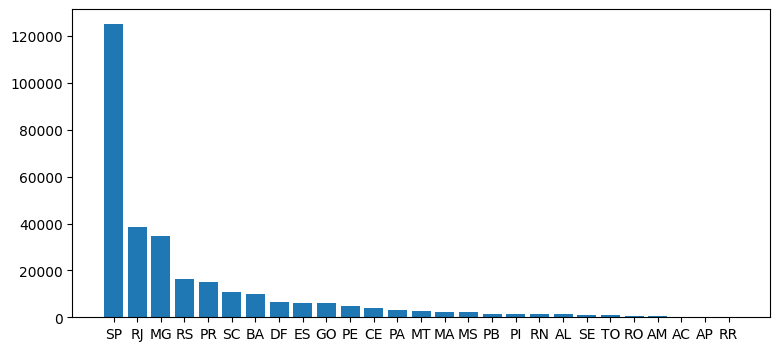

In [7]:
query = """ select customer_state, count(customer_id)
from customers group by customer_state"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customers"])
df = df.sort_values(by = "customers", ascending = False)
# print(df)
plt.figure(figsize = (9,4))
plt.bar(df["state"],df["customers"])


#order per month in 2018

In [8]:
query = """select monthname(order_purchase_timestamp) as month, count(order_id) as orders
from orders
where year(order_purchase_timestamp) = 2018
group by month"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months","orders"])
df

,months,orders
0,July,18876
1,August,19536
2,February,20184
3,June,18501
4,March,21633
5,January,21807
6,May,20619
7,April,20817
8,September,48
9,October,12


# percentage of profit per category.

In [9]:
query = """SELECT products.product_category as category , 
(sum(payments.payment_value) / (select sum(payment_value) from ecommerce.payments)) * 100  as total_sales
FROM ecommerce.products join ecommerce.order_items
on products.product_id = order_items.product_id
join ecommerce.payments
on order_items.order_id = payments.order_id
group by category
order by total_sales desc;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["category","percentage"])
df.head()

,category,percentage
0,bed table bath,10.697529
1,HEALTH BEAUTY,10.352841
2,computer accessories,9.902824
3,Furniture Decoration,8.933649
4,Watches present,8.927654


# Identify the correlation between product price and the number of times a product has been purchased.

In [10]:
query = """SELECT products.product_category, count(order_items.product_id) as orders,
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category","Orders","price"])

arr1 = df["Orders"]
arr2 = df["price"]

x = np.corrcoef([arr1,arr2])
x[0][1]

np.float64(-0.10631514167157562)

# Rand the sellers by revenue.

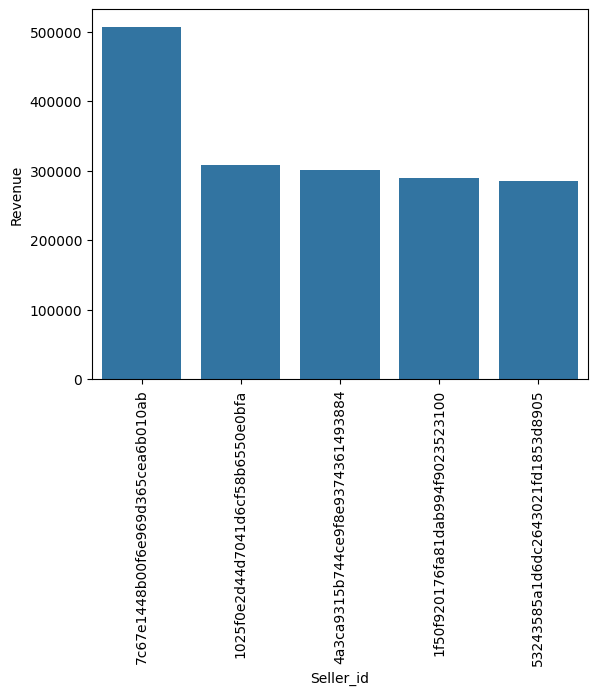

In [11]:
query = """select *,dense_rank() over(order by Revenue desc) as Ranking from
(SELECT order_items.seller_id, sum(payments.payment_value) as Revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Seller_id","Revenue","Ranking"])
df = df.head()

sns.barplot(x = "Seller_id", y = "Revenue", data = df)
plt.xticks(rotation =90)
plt.show()

In [12]:
query = """select customer_id, order_purchase_timestamp, avg(payment_value)
over(partition by customer_id
order by order_purchase_timestamp rows between 2 preceding and current row) as mov_avg
from
(SELECT orders.customer_id, orders.order_purchase_timestamp, payments.payment_value
from orders join payments
on orders.order_id = payments.order_id) as a;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
...,...,...,...
311653,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.500000
311654,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.500000
311655,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.370001
311656,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.370001


# commutative sales per month of each year

In [13]:
query = """select years, months, price, round(sum(price) over(order by years, months),2) as comm_sales
from
(SELECT year(order_purchase_timestamp) as years, month(order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as price
FROM orders join payments
on orders.order_id = payments.order_id
group by months, years order by years, months) as a;"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ["year","month","sales","commutative_"])
df

,year,month,sales,commutative_
0,2016,9,756.72,756.72
1,2016,10,177271.44,178028.16
2,2016,12,58.86,178087.02
3,2017,1,415464.12,593551.14
4,2017,2,875724.03,1469275.17
5,2017,3,1349590.80,2818865.97
6,2017,4,1253364.09,4072230.06
7,2017,5,1778756.46,5850986.52
8,2017,6,1533829.14,7384815.66
9,2017,7,1777148.76,9161964.42


# year over year growth rate per year

In [15]:
query = """with a as (SELECT year(order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as price
FROM orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, (price - lag(price,1) 
over(order by years))/(lag(price,1) 
over(order by years))*100 as growth_per_years from a;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data , columns = ["years","growty rate"])
df

,years,growty rate
0,2016,NaN
1,2017,12112.703756
2,2018,20.000924


,years,customers,payments,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,4270.650146,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,4202.219971,2
2,2016,4a06381959b6670756de02e07b83815f,3683.340088,3
3,2017,1617b1357756262bfa56ab541c47bc16,40992.240234,1
4,2017,c6e2731c5b391845f6800c97401a43a9,20787.930176,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,20179.980469,3
6,2018,ec5b2ba62e574342386871631fafd3fc,21824.639648,1
7,2018,f48d464a0baaea338cb25f816991ab1f,20766.629883,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,14428.319824,3


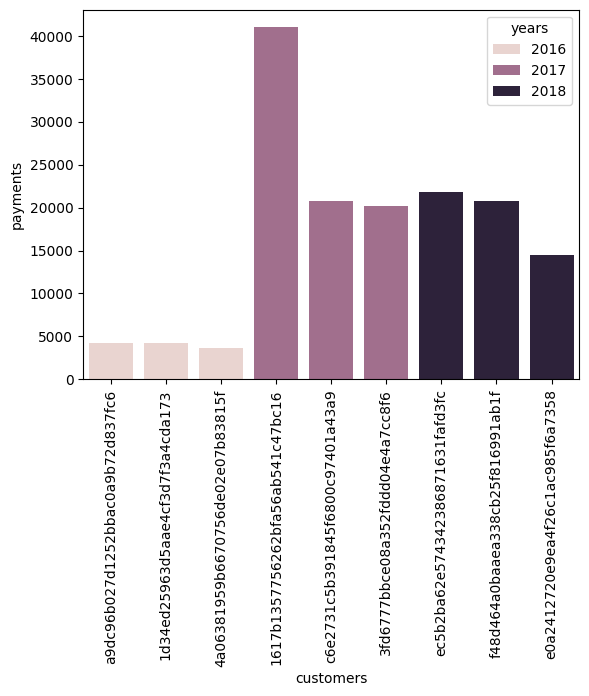

In [33]:
query = """select years, orders, payments, Ranks from 
(SELECT year(orders.order_purchase_timestamp) as years, orders.customer_id as orders, 
sum(payments.payment_value) as payments,
dense_rank() over( partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) as Ranks
FROM orders join payments
on orders.order_id = payments.order_id
group by customer_id, year(orders.order_purchase_timestamp))as a 
where Ranks <= 3; """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","customers","payments","rank"])
sns.barplot(y = "payments", x = "customers", data = df, hue = "years")

plt.xticks(rotation = 90)
df